# Predicting extreme wind speeds in Denmark

The goal of this notebook is to predict extreme wind speeds in Denmark using data from 1.1.1995 to 31.12.2017 (data from www.tutiempo.net). Increasing extreme weather events in combination with ramping up the wind power production may obviously lead to changes in the wind speeds.
In order to investigate the influences of those recent events and identifiyng trends, data from five different weather stations all over Denmark is compared. The data will be modelled in a Bayesian framework aiming at providing information on the probability of storm occurrences in years to come.

# Model description

The likelihood of the extreme wind speeds will be modeled using a generalized pareto distribution that is used for extreme value analysis. Therefore, a cut-off wind speed is needed at which the data will be trimmed. The generalized pareto distribution has three parameters, the location parameter $ \mu $, the scale parameter $\sigma$ and the shape parameter $\xi$. The probability density function is given as
$$
f_{\xi,\mu,\sigma}(x) = \frac{1}{\sigma} \left( 1 + \frac{\xi(x-\mu)}{\sigma} \right)^{\left( -\frac{1}{\xi} - 1 \right)}
$$
<br>
where the validity is given for x $ \geq \mu$ when $\xi  \geq$ 0 and $\mu \leq x \leq \mu - \sigma/\xi$ when $\xi < 0$. In order to find appropriate tail cut off values, Q-Q plots were used to identify possible candidates. This has to ensure a homogeneous behavior of the tail as well as there are enough data points left in the tail.

# Setting up the python environment
For the following data visualizations, in a first step the python environment is prepared.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import seaborn as sns
from scipy.interpolate import UnivariateSpline

import pystan
from psis import psisloo,sumlogs
import stan_utility

/home/felix/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# default plot settings
plt.rc('font', size = 12)

In [3]:
# load data 
city_name_end = ['cop','aar','aal','ode','esb']
for i,my_city in enumerate(city_name_end):
    init_data = np.load('winddata'+my_city+'.npy')
    ii = np.where(init_data != '-1')
    init_data = init_data[ii]
    init_data = np.array(init_data, dtype= 'float64')
    if i == 0:
        wind_data = np.sort(init_data)
    else:
        wind_data = np.append(wind_data,np.sort(init_data))

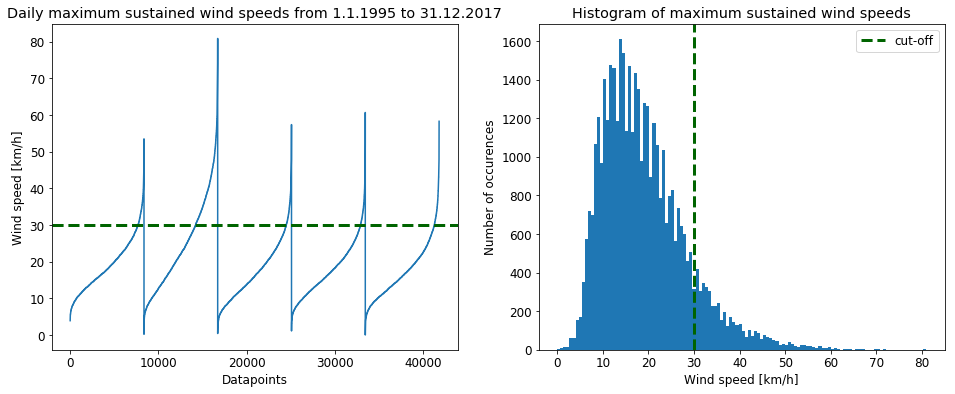

In [4]:
fig, axes = plt.subplots(ncols = 2, figsize = (16,6))

ax = axes[0]
ax.plot(wind_data)
ax.set_title('Daily maximum sustained wind speeds from 1.1.1995 to 31.12.2017')
ax.set_xlabel('Datapoints'); ax.set_ylabel('Wind speed [km/h]')
ax.axhline(y= 30, color = 'darkgreen', linestyle = 'dashed', lw = 3)

ax = axes[1]
ax.hist(wind_data.astype(np.float),bins='auto')
ax.set_title('Histogram of maximum sustained wind speeds')
ax.axvline(x= 30, color = 'darkgreen', linestyle = 'dashed', lw = 3, label = 'cut-off')
ax.set_xlabel('Wind speed [km/h]'); ax.set_ylabel('Number of occurences'); ax.legend()

/home/felix/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2062: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)
/home/felix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1037: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/felix/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2306: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Text(0.5,1,'QQ-plot for Normal distribution for all data')

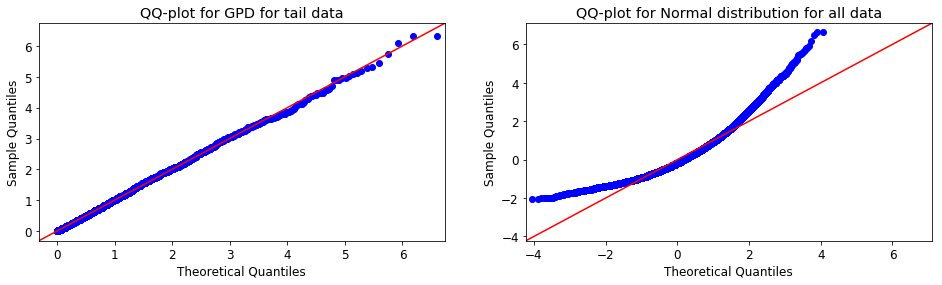

In [5]:
# now test the cut-off
tail_cutoff = 30
tail_bool = wind_data > tail_cutoff
tail_data = wind_data[tail_bool]

# visualize fit to GPD distribution
fig, axes = plt.subplots(nrows = 1,ncols = 2, figsize = (16,4))

qqp = sm.ProbPlot(tail_data - 30, stats.genpareto , fit= True)
qqp.qqplot(line='45',ax = axes[0])
axes[0].set_title('QQ-plot for GPD for tail data')

qqp = sm.ProbPlot(wind_data, stats.norm , fit= True)
qqp.qqplot(line='45',ax = axes[1])
axes[1].set_title('QQ-plot for Normal distribution for all data')


# Prior choices

In order to understand which priors might be useful, the different parameters and their influence on the shape of the GPD will be shown.

In [6]:
def gpareto_pdf(x, u, sigma, k):
    # generalized pareto for point y, cutoff u, scale sigma and shape k
    if abs(k) < 10**(-15):
        return (1/sigma)*np.exp((-(x-u))/sigma)
    else:
        # take the support into account
        y = np.zeros([len(x)])
        if k < 0:
            x_sup = x[x <= tail_cutoff-sigma/k]
        else:
            x_sup = x[x >= tail_cutoff]
        y[0:len(x_sup)] = (1/sigma)*np.power((1+k*(x_sup-u)/sigma),(-1/k-1)) 
        return y

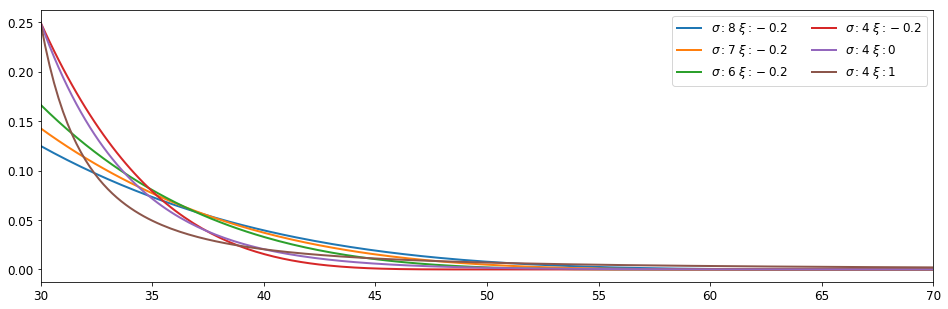

In [7]:
sigma_test = [8,7,6,4,4,4]
k_test = [-0.2,-0.2,-0.2,-0.2,0,1]
fig = plt.figure(figsize = (16,5))
x = np.linspace(tail_cutoff,70,200)
for i,k in enumerate(k_test):
    y = gpareto_pdf(x,tail_cutoff, sigma_test[i], k)
    plt.plot((x),(y),linewidth = 2, label = r'$\sigma: {1} \; \xi: {0}$'.format(k,sigma_test[i]))
plt.xlim([tail_cutoff,70])
plt.legend(ncol  = 2)

Using a prior on either $\sigma$ or $\xi$ seems very sensitive. Giving estimates of the chosen parameters would require to find a trade off between those two parameters.

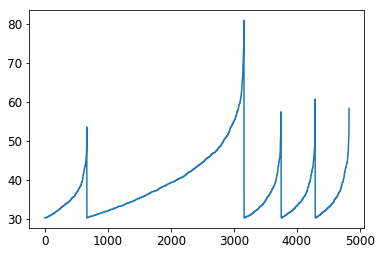

In [24]:
# Prepare data for stan model
peaks = np.where(np.diff(tail_data)<0)[0] #All peaks except the last one.
dstart = np.append([1],peaks+2) # indexing cities
dend   = np.append(peaks+1,[len(tail_data)]) # indexing cities

ymin = tail_data[dstart-1]
ymax = tail_data[dend-1]
N = len(tail_data)
cti = len(city_name_end) # number of cities to include
ctsf = 0 #city start from (0.,4)
plt.plot(tail_data)

data = dict(
    N = dend[ctsf+cti-1]-dstart[ctsf]+1,#,N,
    y = tail_data[dstart[ctsf]-1:dend[ctsf+cti-1]],   # observations
    K = cti,
    ymin = np.array([ymin[ctsf:ctsf+cti]])[0,:],
    ymax = np.array([ymax[ctsf:ctsf+cti]])[0,:],
    dstart = np.array([dstart[ctsf:ctsf+cti]]-dstart[ctsf]+1)[0,:],
    dend = np.array([dend[ctsf:ctsf+cti]]-dstart[ctsf]+1)[0,:],
)


In [9]:
with open('wind_sep.stan') as file:
    print(file.read())

//separate model for GPD
functions {
  real gpareto_lpdf(vector y, real ymin, real k, real sigma) {
    // generalised Pareto log pdf 
    int N = rows(y);
    real inv_k = inv(k);
    if (k<0 && max(y-ymin)/sigma > -inv_k)
      reject("k<0 and max(y-ymin)/sigma > -1/k; found k, sigma =", k, sigma)
    if (sigma<=0)
      reject("sigma<=0; found sigma =", sigma)
    if (fabs(k) > 1e-15)
      return -(1+inv_k)*sum(log1p((y-ymin) * (k/sigma))) -N*log(sigma);
    else
      return -sum(y-ymin)/sigma -N*log(sigma); // limit k->0
  }
  real gpareto_rng(real ymin, real k, real sigma) {
    // generalised Pareto rng
    if (sigma<=0)
      reject("sigma<=0; found sigma =", sigma)
    if (fabs(k) > 1e-15)
      return ymin + (uniform_rng(0,1)^-k -1) * sigma / k;
    else
      return ymin - sigma*log(uniform_rng(0,1)); // limit k->0
   }
  real gpareto_lccdf(vector y, real ymin, real k, real sigma) {
    // generalised Pareto log ccdf
    real inv_k = inv(k);
    if (k<0 && max(y-ymin)/sigma

In [10]:
model_sep = stan_utility.compile_model('wind_sep.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f80565695fadbda590160f53c6f85e22 NOW.


# Now the hierarchichal model

In [11]:
with open('wind_hier.stan') as file:
    print(file.read())

//Hierarchical model for the generalized pareto distribution
functions {
  real gpareto_lpdf(vector y, real ymin, real k, real sigma) {
    // generalised Pareto log pdf 
    int N = rows(y);
    real inv_k = inv(k);
    if (k<0 && max(y-ymin)/sigma > -inv_k)
      reject("k<0 and max(y-ymin)/sigma > -1/k; found k, sigma =", k, sigma)
    if (sigma<=0)
      reject("sigma<=0; found sigma =", sigma)
    if (fabs(k) > 1e-15)
      return -(1+inv_k)*sum(log1p((y-ymin) * (k/sigma))) -N*log(sigma);
    else
      return -sum(y-ymin)/sigma -N*log(sigma); // limit k->0
  }
  real gpareto_lccdf(vector y, real ymin, real k, real sigma) {
    // generalised Pareto log ccdf
    real inv_k = inv(k);
    if (k<0 && max(y-ymin)/sigma > -inv_k)
      reject("k<0 and max(y-ymin)/sigma > -1/k; found k, sigma =", k, sigma)
    if (sigma<=0)
      reject("sigma<=0; found sigma =", sigma)
    if (fabs(k) > 1e-15)
      return (-inv_k)*sum(log1p((y-ymin) * (k/sigma)));
    else
      return -sum(y-ymin)/si

In [12]:
model_hier = stan_utility.compile_model('wind_sep.stan')

Using cached StanModel


# Analysis of the hierachichal model
Start with getting the samples


In [13]:
fit_hier = model_hier.sampling(data=data, seed = 12863)
samples_hier = fit_hier.extract(permuted = True)

/home/felix/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


-------cop------------
Sigma: 5.18
K-value: -0.16
Chance storm > 74km/h: 0.0 %


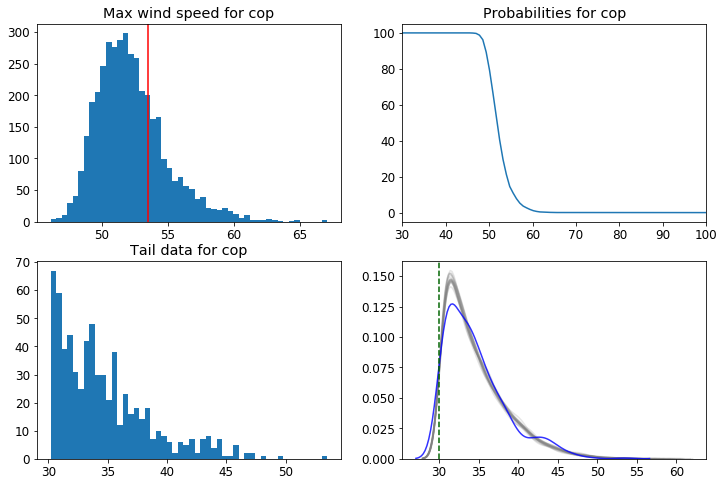

-------aar------------
Sigma: 12.18
K-value: -0.21
Chance storm > 74km/h: 95.225 %


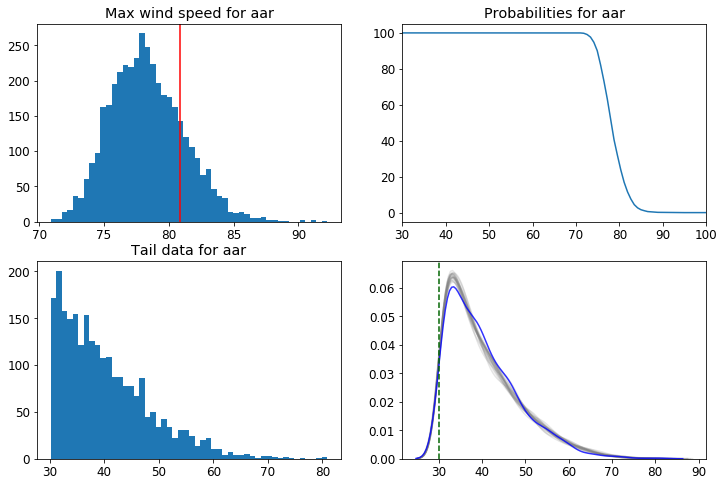

-------aal------------
Sigma: 5.16
K-value: -0.04
Chance storm > 74km/h: 5.2 %


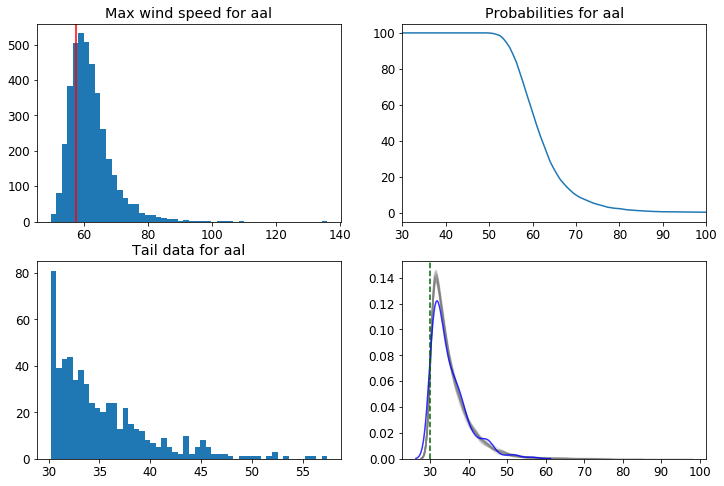

-------ode------------
Sigma: 5.10
K-value: -0.05
Chance storm > 74km/h: 3.025 %


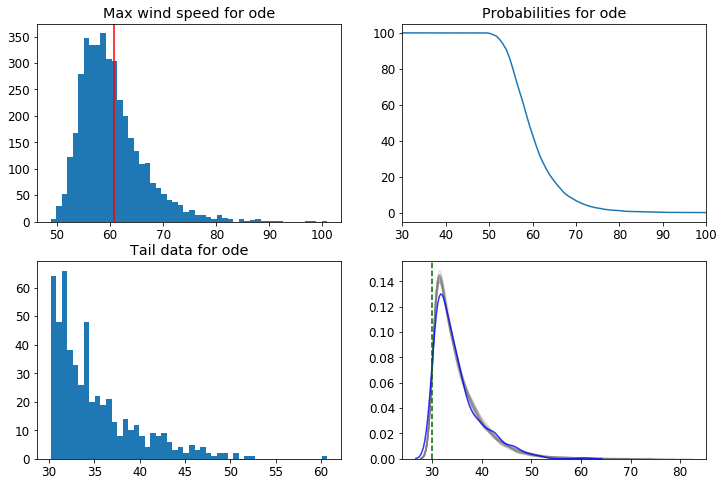

-------esb------------
Sigma: 5.76
K-value: -0.10
Chance storm > 74km/h: 0.925 %


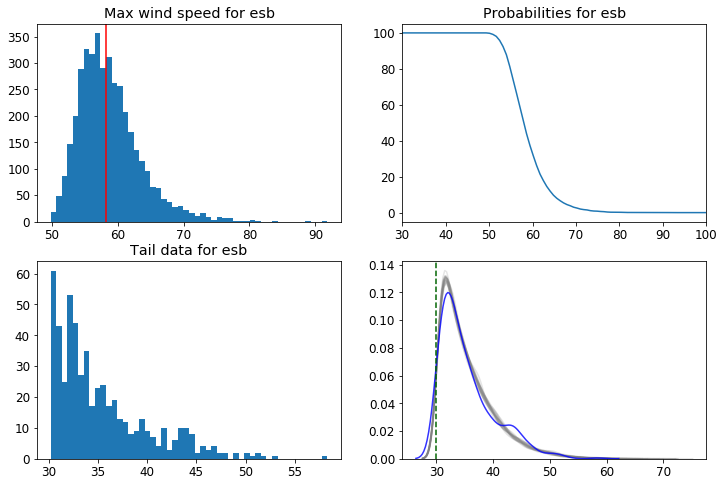

In [14]:
# show some results
yrep_hier = samples_hier['yrep']
for i,my_city in enumerate(city_name_end):
    print('-------{0}------------'.format(my_city))
    print('Sigma: {:.2f}'.format(np.mean(samples_hier['sigma'][:,i])))
    print('K-value: {:.2f}'.format(np.mean(samples_hier['k'][:,i])))
    print('Chance storm > 74km/h: {0} %'.format(100*len([i for i in np.max(yrep_hier[:,dstart[i]:dend[i]],axis = 1) if i > 74])/len(yrep_hier[:,dstart[i]:dend[i]])))
    
    # also visualize some
    fig,axes = plt.subplots(nrows = 2, ncols = 2, figsize=(12,8))
    ax = axes[0,0]
    ax.hist(np.max(yrep_hier[:,dstart[i]:dend[i]],axis = 1), bins = 50)
    ax.axvline(x = max(tail_data[dstart[i]:dend[i]]), color = 'red', label = 'max y')
    ax.set_title('Max wind speed for {0}'.format(my_city))
    ax = axes[0,1]
    xnew = np.linspace(tail_cutoff,184,200)
    ynew = list()
    for xn in xnew:
        ynew.append(100*len([p for p in np.max(yrep_hier[:,dstart[i]:dend[i]],axis = 1) if p > xn])/len(yrep_hier[:,dstart[i]:dend[i]]))
    ax.plot(xnew,ynew)
    ax.set_xlim([30,100])
    #qqp = sm.ProbPlot(tail_data - tail_cutoff, stats.genpareto , fit= True)
    #qqp.qqplot(line='45', ax = ax)
    #ax.set_title('QQ - {0}'.format(my_city))
    #ax.hist(samples['yrep'][0])
    ax.set_title('Probabilities for {0}'.format(my_city))
    ax = axes[1,0]
    ax.hist(tail_data[dstart[i]:dend[i]], bins = 50)
    ax.set_title('Tail data for {0}'.format(my_city))
    ax = axes[1,1]
    for draw in range(0,20):
        sigma_draws = samples_hier['sigma'][draw:draw+1,i]
        k_draws = samples_hier['k'][draw:draw+1,i]
        sns.kdeplot(samples_hier['yrep'][:,dstart[i] + draw], alpha = 0.2, color="gray")
    sigma_mean = np.mean(samples_hier['sigma'][:,i])
    k_mean = np.mean(samples_hier['k'][:,i])
    #y = gpareto_pdf(x,tail_cutoff, sigma_mean, k_mean)
    #ax.plot((x),(y),'k',linewidth = 4, label = 'gp_pdf(mean sigma, mean k)')
    sns.kdeplot(tail_data[dstart[i]:dend[i]], alpha = 0.8, color="blue")
    ax.axvline(x = (tail_cutoff), color = 'darkgreen',linestyle = 'dashed', label = 'cutoff')
    plt.show()

# PSIS LOO for hierarchichal

P-eff: 9.9700954933287
LOO-sep -14219.148678223599


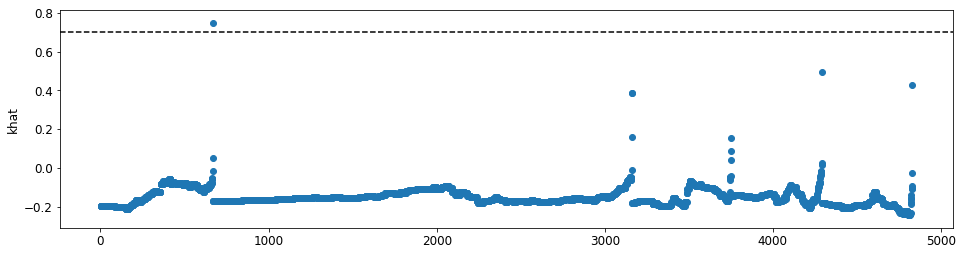

In [15]:
log_like = samples_hier['log_lik']
loo_hier, loos, ks_hier = psisloo(log_like)
lppd_hier = np.sum(np.log(np.mean(np.exp(log_like), axis=0)))
peff_hier = lppd_hier - loo_hier
fig = plt.figure(figsize = (16,4))
plt.scatter(np.arange(1, len(ks_hier) + 1),ks_hier)
plt.axhline(y=0.7, linestyle = '--', color = 'k')
plt.ylabel('khat')
print('P-eff:',peff_hier)
print('LOO-sep',loo_hier)

# Analysis of the separate model
start with getting the samples

In [16]:
fit_sep = model_sep.sampling(data=data, seed = 192863)
samples_sep = fit_sep.extract(permuted = True)

/home/felix/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


-------cop------------
Sigma: 5.18
K-value: -0.16
Chance storm > 74km/h: 0.025 %


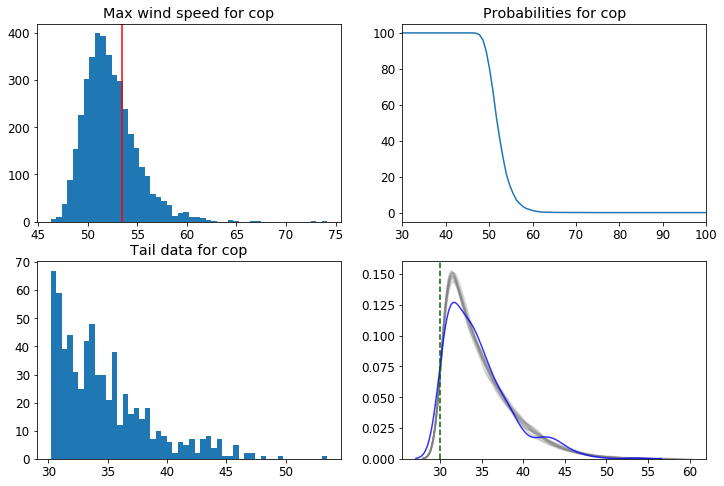

-------aar------------
Sigma: 12.19
K-value: -0.21
Chance storm > 74km/h: 95.475 %


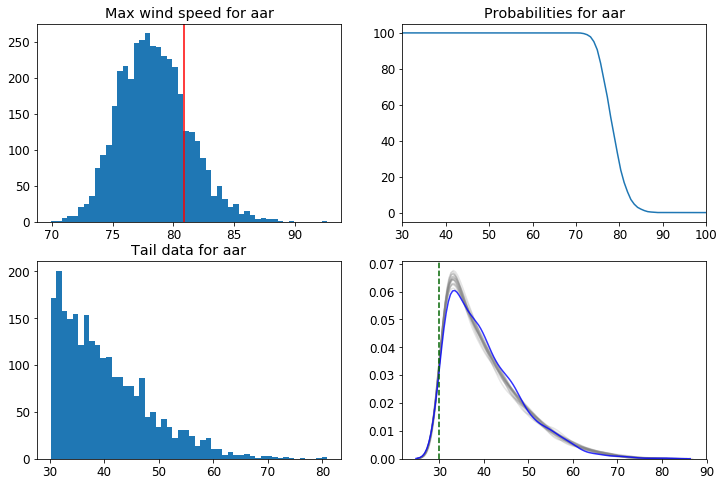

-------aal------------
Sigma: 5.17
K-value: -0.04
Chance storm > 74km/h: 4.6 %


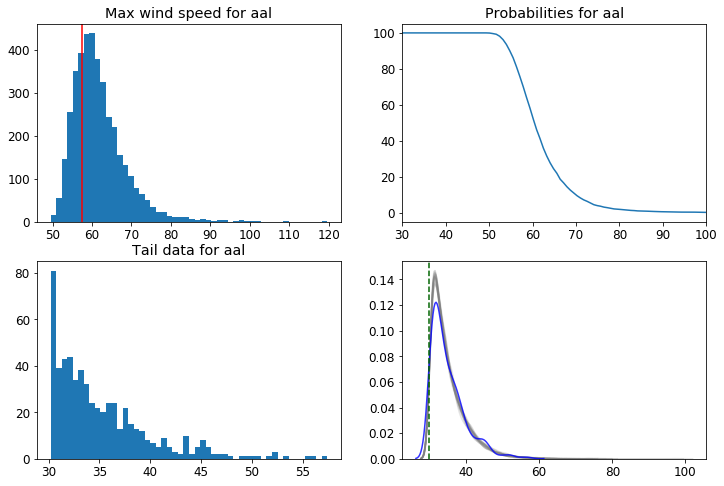

-------ode------------
Sigma: 5.10
K-value: -0.05
Chance storm > 74km/h: 2.95 %


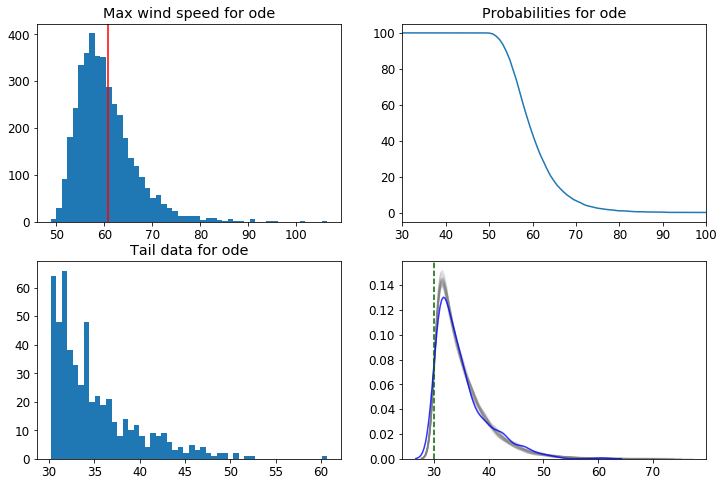

-------esb------------
Sigma: 5.76
K-value: -0.10
Chance storm > 74km/h: 1.4 %


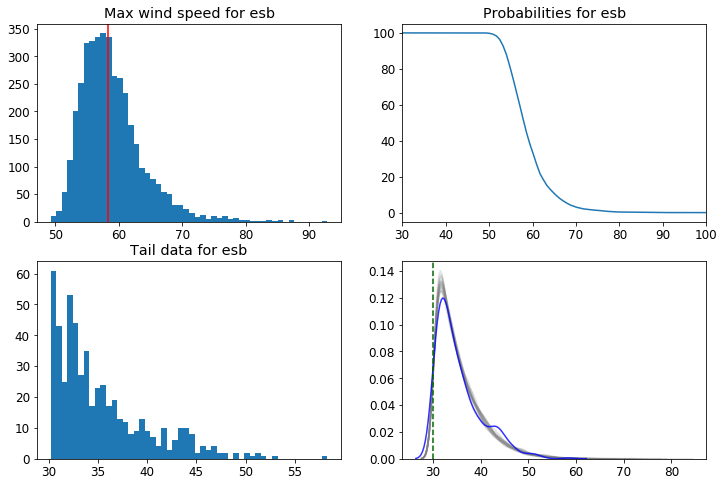

In [17]:
# show some results
yrep_sep = samples_sep['yrep']
for i,my_city in enumerate(city_name_end):
    print('-------{0}------------'.format(my_city))
    print('Sigma: {:.2f}'.format(np.mean(samples_sep['sigma'][:,i])))
    print('K-value: {:.2f}'.format(np.mean(samples_sep['k'][:,i])))
    print('Chance storm > 74km/h: {0} %'.format(100*len([i for i in np.max(yrep_sep[:,dstart[i]:dend[i]],axis = 1) if i > 74])/len(yrep_sep[:,dstart[i]:dend[i]])))
    
    # also visualize some
    fig,axes = plt.subplots(nrows = 2, ncols = 2, figsize=(12,8))
    ax = axes[0,0]
    ax.hist(np.max(yrep_sep[:,dstart[i]:dend[i]],axis = 1), bins = 50)
    ax.axvline(x = max(tail_data[dstart[i]:dend[i]]), color = 'red', label = 'max y')
    ax.set_title('Max wind speed for {0}'.format(my_city))
    ax = axes[0,1]
    xnew = np.linspace(tail_cutoff,184,200)
    ynew = list()
    for xn in xnew:
        ynew.append(100*len([p for p in np.max(yrep_sep[:,dstart[i]:dend[i]],axis = 1) if p > xn])/len(yrep_sep[:,dstart[i]:dend[i]]))
    ax.plot(xnew,ynew)
    ax.set_xlim([30,100])
    #qqp = sm.ProbPlot(tail_data - tail_cutoff, stats.genpareto , fit= True)
    #qqp.qqplot(line='45', ax = ax)
    #ax.set_title('QQ - {0}'.format(my_city))
    #ax.hist(samples['yrep'][0])
    ax.set_title('Probabilities for {0}'.format(my_city))
    ax = axes[1,0]
    ax.hist(tail_data[dstart[i]:dend[i]], bins = 50)
    ax.set_title('Tail data for {0}'.format(my_city))
    ax = axes[1,1]
    for draw in range(0,20):
        sigma_draws = samples_sep['sigma'][draw:draw+1,i]
        k_draws = samples_sep['k'][draw:draw+1,i]
        sns.kdeplot(samples_sep['yrep'][:,dstart[i] + draw], alpha = 0.2, color="gray")
    sigma_mean = np.mean(samples_sep['sigma'][:,i])
    k_mean = np.mean(samples_sep['k'][:,i])
    #y = gpareto_pdf(x,tail_cutoff, sigma_mean, k_mean)
    #ax.plot((x),(y),'k',linewidth = 4, label = 'gp_pdf(mean sigma, mean k)')
    sns.kdeplot(tail_data[dstart[i]:dend[i]], alpha = 0.8, color="blue")
    ax.axvline(x = (tail_cutoff), color = 'darkgreen',linestyle = 'dashed', label = 'cutoff')
    plt.show()

# PSIS - LOO analysis


P-eff: 9.784458659998563
LOO-sep -14218.982527683951


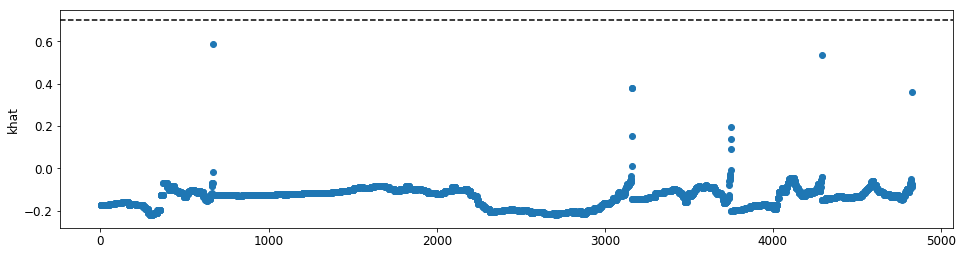

In [18]:
log_like = samples_sep['log_lik']
loo_sep, loos, ks_sep = psisloo(log_like)
lppd_sep = np.sum(np.log(np.mean(np.exp(log_like), axis=0)))
peff_sep = lppd_sep - loo_sep
fig = plt.figure(figsize = (16,4))
plt.scatter(np.arange(1, len(ks_sep) + 1),ks_sep)
plt.axhline(y=0.7, linestyle = '--', color = 'k')
plt.ylabel('khat')
print('P-eff:',peff_sep)
print('LOO-sep',loo_sep)

# Cut data in chunk pieces and use model to predict xi and sigma

In [19]:
n_splits = 5 # 20/n_splits = time intervals
sigmas = np.zeros((n_splits, len(city_name_end)))
ks = np.zeros((n_splits,len(city_name_end)))
for n_split in range(n_splits):
    # load data 
    for i,my_city in enumerate(city_name_end):
        init_data = np.load('winddata'+my_city+'.npy')
        n_cut = int(len(init_data)/n_splits)
        init_data = init_data[n_split*n_cut:(n_split + 1)*n_cut]
        ii = np.where(init_data != '-1')
        init_data = init_data[ii]
        init_data = np.array(init_data, dtype= 'float64')
        if i == 0:
            wind_data_cut = np.sort(init_data)
        else:
            wind_data_cut = np.append(wind_data_cut,np.sort(init_data))
    # separate model
    tail_bool_cut = wind_data_cut > tail_cutoff
    tail_data_cut = wind_data_cut[tail_bool_cut]
    # Prepare data for stan model
    peaks = np.where(np.diff(tail_data_cut)<0)[0] #All peaks except the last one.
    dstart_cut = np.append([1],peaks+2) # indexing cities
    dend_cut   = np.append(peaks+1,[len(tail_data_cut)]) # indexing cities

    ymin = tail_data_cut[dstart_cut-1]
    ymax = tail_data_cut[dend_cut-1]
    N = len(tail_data_cut)
    cti = len(city_name_end) # number of cities to include
    ctsf = 0 #city start from (0.,4)

    data = dict(
        N = dend_cut[ctsf+cti-1]-dstart_cut[ctsf]+1,#,N,
        y = tail_data_cut[dstart_cut[ctsf]-1:dend_cut[ctsf+cti-1]],   # observations
        K = cti,
        ymin = np.array([ymin[ctsf:ctsf+cti]])[0,:],
        ymax = np.array([ymax[ctsf:ctsf+cti]])[0,:],
        dstart = np.array([dstart_cut[ctsf:ctsf+cti]]-dstart_cut[ctsf]+1)[0,:],
        dend = np.array([dend_cut[ctsf:ctsf+cti]]-dstart_cut[ctsf]+1)[0,:],
    )
    
    #now use whichever model
    fit_hier = model_hier.sampling(data=data, seed = 12863)
    samples_hier = fit_hier.extract(permuted = True)
    
    sigmas[n_split,:] = np.mean(samples_hier['sigma'],axis=0)
    ks[n_split,:] = np.mean(samples_hier['k'],axis=0)

/home/felix/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Text(0,0.5,'$\\sigma$')

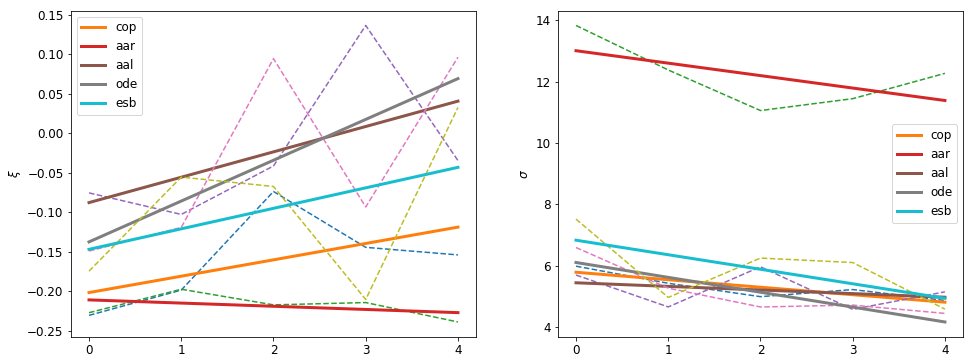

In [20]:
# visualize splits
fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize=(16,6))
ax = axes[0]
for i in range(ks.shape[1]):
    ax.plot(ks[:,i], ls = '--')
    ax.set_xticks(np.arange(n_splits))
    x = np.arange(n_splits)
    spl = UnivariateSpline(x, ks[:,i], k =1)
    xs = np.linspace(0, n_splits - 1, 100)
    ax.plot(xs, spl(xs), lw=3, label = city_name_end[i])
ax.legend(loc = 'best')
ax.set_ylabel(r'$\xi$')

ax = axes[1]
for i in range(sigmas.shape[1]):
    ax.plot(sigmas[:,i], ls = '--')
    ax.set_xticks(np.arange(n_splits))
    spl = UnivariateSpline(x, sigmas[:,i],k = 1)
    xs = np.linspace(0, n_splits - 1, 100)
    ax.plot(xs, spl(xs), lw=3,label = city_name_end[i])
ax.legend(loc = 'best')
ax.set_ylabel(r'$\sigma$')

# Future predictions

The model suggests larger k values and smaller sigma values for future observations. As a scenario the shape parameter will be kept fixed according to the last investigated time frame, while the k-value is set to 0.05. Shown are the maximum predicted wind speeds.

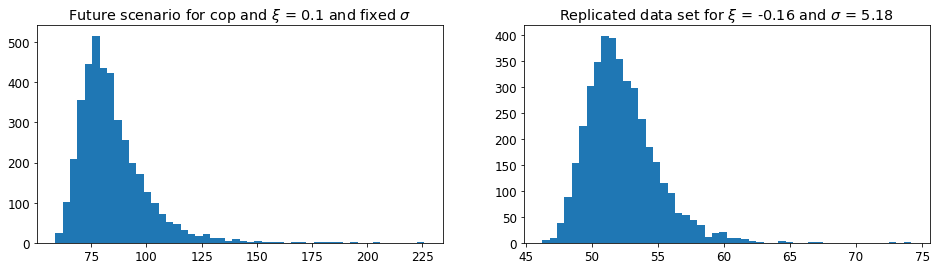

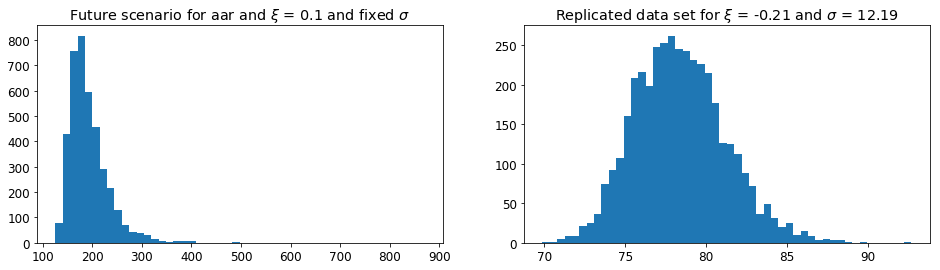

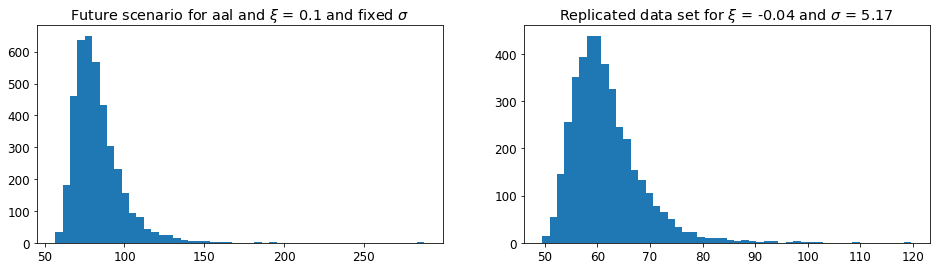

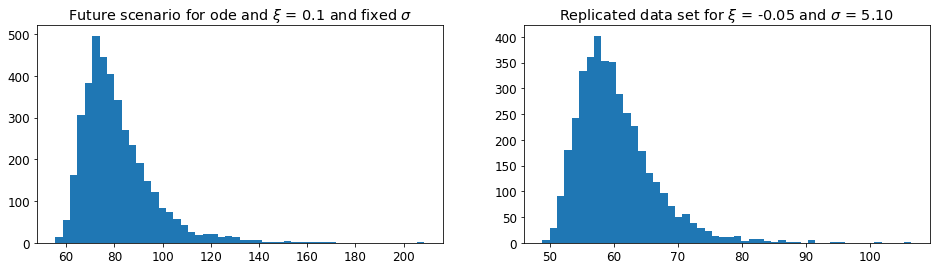

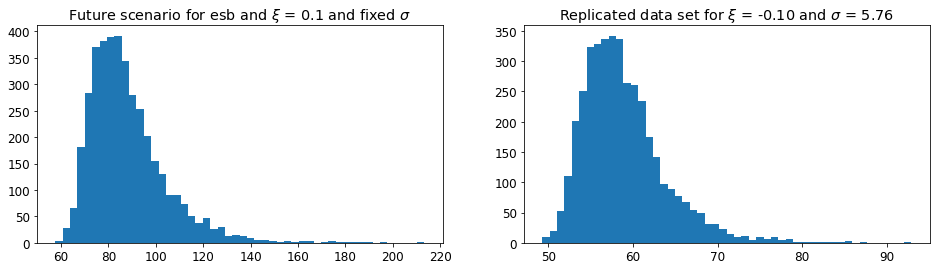

In [31]:
for i,my_city in enumerate(city_name_end):
    fig,axes = plt.subplots(ncols = 2, figsize=(16,4))
    ax = axes[0]
    ax.hist(np.max(samples_sep['yrep_fut'][:,dstart[i]:dend[i]],axis = 1),bins = 50)
    ax.set_title(r'Future scenario for {0} and $\xi$ = 0.1 and fixed $\sigma$'.format(my_city))

    ax = axes[1]
    ax.hist(np.max(samples_sep['yrep'][:,dstart[i]:dend[i]],axis = 1),bins = 50)
    ax.set_title(r'Replicated data set for $\xi$ = {:.2f} and $\sigma$ = {:.2f}'.format(np.mean(samples_sep['k'][:,i]),np.mean(samples_sep['sigma'][:,i])))
    plt.show()